### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from pandas import DatetimeIndex

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math

### Carregamento dos dados

In [2]:
dataOriginal = pd.read_csv('new_Global_Superstore2.csv', index_col=0, comment='#') 
df = dataOriginal 

### Tratamento dos dados

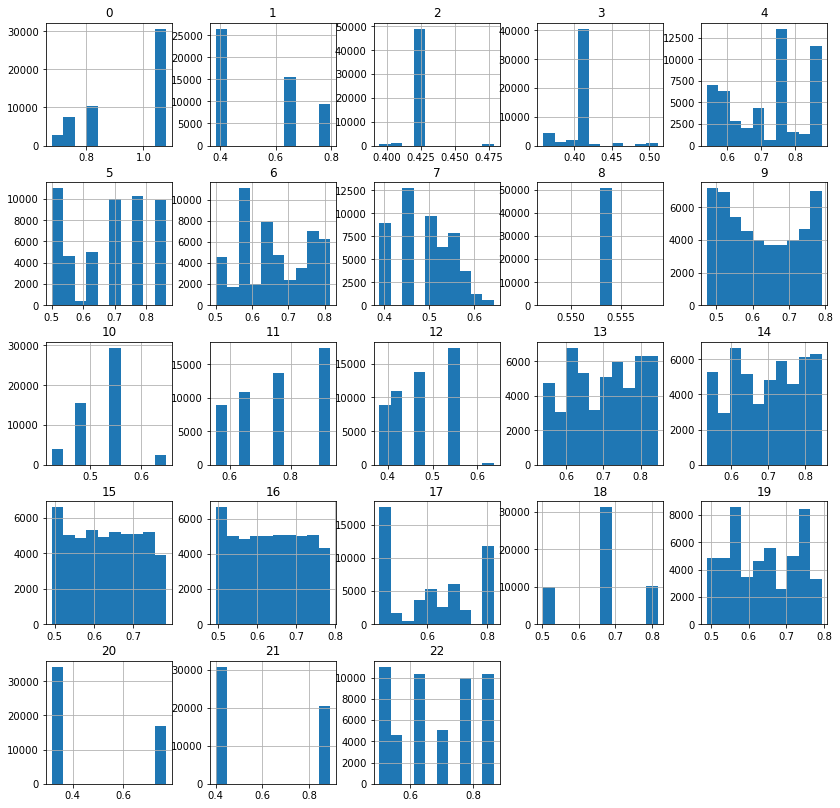

In [20]:

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
'''
Links:
https://stackoverflow.com/questions/44552031/sklearnstandardscaler-can-i-inverse-the-standardscaler-for-the-model-output
https://stackoverflow.com/questions/56936780/how-do-i-correctly-use-the-inverse-transform-method-when-using-powertransformer
'''

y = dataset_MLP[['Profit']]


df = dataOriginal

ss = StandardScaler()
ss.fit(df)
df = pd.DataFrame(ss.transform(df))


skew_cols = []

for coluna in df.columns:
    if df[coluna].skew() > 1:
         skew_cols.append(coluna)
# Skew
if len(skew_cols) > 0:
    df[skew_cols] = pd.DataFrame(pt.fit_transform(df[skew_cols]), columns=skew_cols)
    #print(df3.skew()) 



pt = PowerTransformer()
pt.fit(df)
#df = pt.transform(df)
df = pd.DataFrame(pt.transform(df))

scaler = MinMaxScaler(feature_range = (0,1))
df = scaler.fit_transform(df)
df = pd.DataFrame(scaler.transform(df))
df.hist(figsize=(14, 14));



### Neurónios

In [21]:
#dataset_MLP = dataset.drop(columns=['Order ID', 'Customer ID', 'Customer Name', 'Product ID', 'Product Name', 'Postal Code'])


#dataset_MLP = dataset_MLP.drop(['Order Priority', 'Market', "City", "Segment", "Ship Mode", "Ship Date"], axis=1)
#print(dataset_MLP.info())

In [22]:
import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

RANDOM_SEED = 2021

print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.10.0


In [28]:
dataset_MLP = df

X_MLP = dataset_MLP.drop(8, axis=1)
y_MLP = dataset_MLP[[8]]

small_dataset = True
if small_dataset: 
    remove_n = 20000
    drop_indices = np.random.choice(dataset_MLP.index, remove_n, replace=False)
    dataset_MLP_subset = dataset_MLP.drop(drop_indices)
    X_MLP = dataset_MLP_subset.drop(8, axis=1)
    y_MLP = dataset_MLP_subset[[8]]

 
    
    # Convert data
if "Order Date" in X_MLP:
    consider_year = True
    consider_month = True
    consider_day = True
else: 
    consider_year = False
    consider_month = False
    consider_day = False





In [29]:

# Onde fui buscar algumas coisas:
# https://www.projectpro.io/recipes/find-optimal-parameters-using-gridsearchcv


X_train, X_test, y_train, y_test = train_test_split(X_MLP, y_MLP, test_size=0.2, random_state=RANDOM_SEED)

number_columns = len(X_train.columns)#.count()
#print("Número de colunas: ", number_columns)

def build_model(activation='relu', learning_rate=0.01):
#create a sequential model (with three Layers - Last one is the output)
    model = Sequential()
    model.add(Dense(number_columns, input_dim=number_columns, activation=activation))
    model.add(Dense(6, activation=activation))
    model.add(Dense(1, activation='relu'))
  
     #compile the model
    #Define the Loss function, the otimizer and metrics to be used
    model. compile(
        loss = 'mae',
        optimizer = tf.optimizers.Adam(learning_rate),
        metrics = ['mae', 'mse'])
    return model

model = build_model()
model.summary()
''' Este é melhor, mas mais lento
TUNING_DICT = {
    'activation' : ['relu', 'sigmoid'],
    'learning_rate' : [0.01, 0.001]
}
'''
# = {
#    'activation' : ['relu'],
#    'learning_rate' : [0.01]
#}

TUNING_DICT = {'learning_rate': [0.01,0.03, 0.1],                  
                'activation' : ['relu', 'sigmoid'],
                 }

kf = KFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)

model = KerasRegressor(build_fn=build_model, epochs=15,batch_size=number_columns)
grid_search = GridSearchCV(estimator = model,
                            param_grid = TUNING_DICT,
                            cv = kf,
                            scoring = 'neg_mean_absolute_error',
                            refit ='True',
                            verbose = 1)

grid_search.fit(X_train, y_train, validation_split=0.2)

print(" Results from Grid Search " )
print(grid_search)
#print("\n The best score across ALL searched params:\n",grid_search.best_score_)
#print("\n The best parameters across ALL searched params:\n",grid_search.best_params_)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 22)                506       
                                                                 
 dense_1 (Dense)             (None, 6)                 138       
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 651
Trainable params: 651
Non-trainable params: 0
_________________________________________________________________
Fitting 2 folds for each of 6 candidates, totalling 12 fits


C:\Users\Diogo\AppData\Local\Temp\ipykernel_17676\4099265392.py:44: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=build_model, epochs=15,batch_size=number_columns)


Epoch 1/15
454/454 [==============================] - 3s 4ms/step - loss: 0.0186 - mae: 0.0186 - mse: 0.0011 - val_loss: 0.0042 - val_mae: 0.0042 - val_mse: 2.8141e-05
Epoch 2/15
454/454 [==============================] - 1s 2ms/step - loss: 0.0051 - mae: 0.0051 - mse: 4.4058e-05 - val_loss: 0.0029 - val_mae: 0.0029 - val_mse: 1.3719e-05
Epoch 3/15
454/454 [==============================] - 1s 3ms/step - loss: 0.0036 - mae: 0.0036 - mse: 2.0478e-05 - val_loss: 0.0077 - val_mae: 0.0077 - val_mse: 6.3214e-05
Epoch 4/15
454/454 [==============================] - 1s 3ms/step - loss: 0.0032 - mae: 0.0032 - mse: 1.6109e-05 - val_loss: 0.0011 - val_mae: 0.0011 - val_mse: 1.8992e-06
Epoch 5/15
454/454 [==============================] - 2s 4ms/step - loss: 0.0028 - mae: 0.0028 - mse: 1.2108e-05 - val_loss: 7.8082e-04 - val_mae: 7.8082e-04 - val_mse: 9.3514e-07
Epoch 6/15
454/454 [==============================] - 2s 4ms/step - loss: 0.0022 - mae: 0.0022 - mse: 7.9864e-06 - val_loss: 5.6540e-04 

Epoch 3/15
454/454 [==============================] - 3s 6ms/step - loss: 0.5535 - mae: 0.5535 - mse: 0.3064 - val_loss: 0.5535 - val_mae: 0.5535 - val_mse: 0.3064
Epoch 4/15
454/454 [==============================] - 2s 4ms/step - loss: 0.5535 - mae: 0.5535 - mse: 0.3064 - val_loss: 0.5535 - val_mae: 0.5535 - val_mse: 0.3064
Epoch 5/15
454/454 [==============================] - 1s 3ms/step - loss: 0.5535 - mae: 0.5535 - mse: 0.3064 - val_loss: 0.5535 - val_mae: 0.5535 - val_mse: 0.3064
Epoch 6/15
454/454 [==============================] - 2s 4ms/step - loss: 0.5535 - mae: 0.5535 - mse: 0.3064 - val_loss: 0.5535 - val_mae: 0.5535 - val_mse: 0.3064
Epoch 7/15
454/454 [==============================] - 2s 4ms/step - loss: 0.5535 - mae: 0.5535 - mse: 0.3064 - val_loss: 0.5535 - val_mae: 0.5535 - val_mse: 0.3064
Epoch 8/15
454/454 [==============================] - 1s 2ms/step - loss: 0.5535 - mae: 0.5535 - mse: 0.3064 - val_loss: 0.5535 - val_mae: 0.5535 - val_mse: 0.3064
Epoch 9/15
454/4

Epoch 6/15
454/454 [==============================] - 1s 3ms/step - loss: 0.0052 - mae: 0.0052 - mse: 3.2084e-05 - val_loss: 0.0017 - val_mae: 0.0017 - val_mse: 3.4296e-06
Epoch 7/15
454/454 [==============================] - 1s 3ms/step - loss: 0.0050 - mae: 0.0050 - mse: 2.9394e-05 - val_loss: 0.0038 - val_mae: 0.0038 - val_mse: 1.4765e-05
Epoch 8/15
454/454 [==============================] - 1s 3ms/step - loss: 0.0049 - mae: 0.0049 - mse: 2.6318e-05 - val_loss: 0.0040 - val_mae: 0.0040 - val_mse: 1.6500e-05
Epoch 9/15
454/454 [==============================] - 1s 2ms/step - loss: 0.0048 - mae: 0.0048 - mse: 2.7061e-05 - val_loss: 0.0045 - val_mae: 0.0045 - val_mse: 2.0928e-05
Epoch 10/15
454/454 [==============================] - 1s 2ms/step - loss: 0.0046 - mae: 0.0046 - mse: 2.3912e-05 - val_loss: 0.0052 - val_mae: 0.0052 - val_mse: 2.7831e-05
Epoch 11/15
454/454 [==============================] - 2s 5ms/step - loss: 0.0053 - mae: 0.0053 - mse: 3.8214e-05 - val_loss: 0.0055 - val_

454/454 [==============================] - 2s 4ms/step - loss: 0.5535 - mae: 0.5535 - mse: 0.3064 - val_loss: 0.5535 - val_mae: 0.5535 - val_mse: 0.3064
Epoch 9/15
454/454 [==============================] - 3s 7ms/step - loss: 0.5535 - mae: 0.5535 - mse: 0.3064 - val_loss: 0.5535 - val_mae: 0.5535 - val_mse: 0.3064
Epoch 10/15
454/454 [==============================] - 2s 4ms/step - loss: 0.5535 - mae: 0.5535 - mse: 0.3064 - val_loss: 0.5535 - val_mae: 0.5535 - val_mse: 0.3064
Epoch 11/15
454/454 [==============================] - 2s 4ms/step - loss: 0.5535 - mae: 0.5535 - mse: 0.3064 - val_loss: 0.5535 - val_mae: 0.5535 - val_mse: 0.3064
Epoch 12/15
454/454 [==============================] - 2s 4ms/step - loss: 0.5535 - mae: 0.5535 - mse: 0.3064 - val_loss: 0.5535 - val_mae: 0.5535 - val_mse: 0.3064
Epoch 13/15
454/454 [==============================] - 3s 6ms/step - loss: 0.5535 - mae: 0.5535 - mse: 0.3064 - val_loss: 0.5535 - val_mae: 0.5535 - val_mse: 0.3064
Epoch 14/15
454/454 [==

Epoch 10/15
908/908 [==============================] - 3s 3ms/step - loss: 0.0012 - mae: 0.0012 - mse: 2.1167e-06 - val_loss: 3.0526e-04 - val_mae: 3.0526e-04 - val_mse: 1.0722e-07
Epoch 11/15
908/908 [==============================] - 3s 3ms/step - loss: 9.9734e-04 - mae: 9.9734e-04 - mse: 1.5568e-06 - val_loss: 0.0010 - val_mae: 0.0010 - val_mse: 1.1161e-06
Epoch 12/15
908/908 [==============================] - 3s 3ms/step - loss: 0.0015 - mae: 0.0015 - mse: 3.6829e-06 - val_loss: 6.3641e-04 - val_mae: 6.3641e-04 - val_mse: 4.2106e-07
Epoch 13/15
908/908 [==============================] - 3s 3ms/step - loss: 0.0013 - mae: 0.0013 - mse: 2.1317e-06 - val_loss: 0.0014 - val_mae: 0.0014 - val_mse: 2.0843e-06
Epoch 14/15
908/908 [==============================] - 3s 3ms/step - loss: 0.0012 - mae: 0.0012 - mse: 2.0579e-06 - val_loss: 4.0919e-04 - val_mae: 4.0919e-04 - val_mse: 1.8075e-07
Epoch 15/15
908/908 [==============================] - 3s 4ms/step - loss: 8.7009e-04 - mae: 8.7009e-04

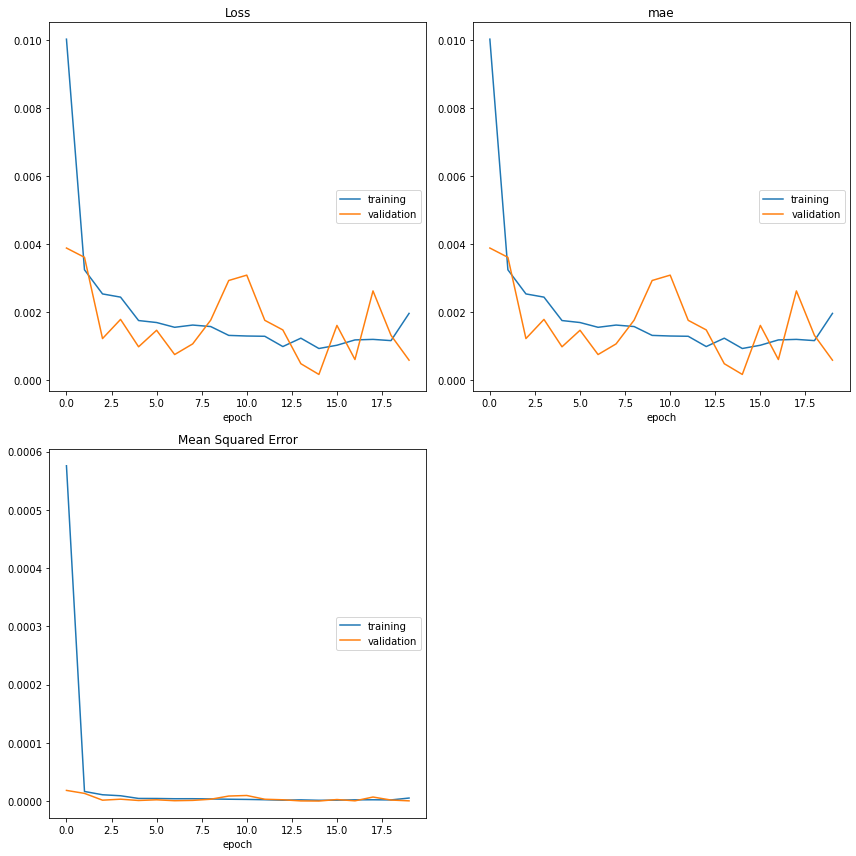

Loss
	training         	 (min:    0.001, max:    0.010, cur:    0.002)
	validation       	 (min:    0.000, max:    0.004, cur:    0.001)
mae
	training         	 (min:    0.001, max:    0.010, cur:    0.002)
	validation       	 (min:    0.000, max:    0.004, cur:    0.001)
Mean Squared Error
	training         	 (min:    0.000, max:    0.001, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
1135/1135 [==============================] - 4s 4ms/step - loss: 0.0020 - mae: 0.0020 - mse: 5.1718e-06 - val_loss: 5.8643e-04 - val_mae: 5.8642e-04 - val_mse: 3.5810e-07


In [30]:
# Overfitting analisys

#Our best model (remember we set refit
best_mlp_model = grid_search.best_estimator_

from livelossplot import PlotLossesKerasTF
best_mlp_model.fit(X_train, y_train, epochs=20,
validation_data=(X_test, y_test),
callbacks=[PlotLossesKerasTF()], verbose=1)

### Análise de overfitting

Pelos gráficos, vemos que o medium average error (mae) dá bastante mal, mas o mse dá bem. Como 20 epochs é um valor considerável, consideramos nesta fase melhorar o tratamento de dados, e depois verificar se há melhorias. 
Isto porque, o tratamento de dados atual para este modelo é quase com o objetivo de o modelo consiguir analisar o dataset.

In [35]:
 #0btain predictions

predictions = best_mlp_model.predict(X_test)
print(predictions)
inversed = ss.inverse_transform(pd.DataFrame(predictions))
#inversed[skew_cols] = pd.DataFrame(pt.inverse_transform(inversed[skew_cols]), columns=skew_cols)

print(inversed)

284/284 [==============================] - 1s 2ms/step
[0.55408496 0.55408496 0.55408496 ... 0.55408496 0.55408496 0.55408496]


ValueError: non-broadcastable output operand with shape (6240,1) doesn't match the broadcast shape (6240,23)

In [ ]:
y_test_unscaled = scaler_y.inverse_transform(y_test)

#Visualising the actual and predicted result
def real_predicted_viz(limit):
    plt.figure(figsize=(14,6))
    plt.plot(y_test_unscaled[:limit], color = 'green', label = 'Actual')
    plt.plot (predicions_unscaled[:limit], color = 'red', label = 'Predicted')
    plt.grid(alpha = 0.3)
    plt.xlabel('Sample')
    plt.ylabel ('Profit')
    plt.title('Real vs Predicted')
    plt.legend()
    plt.show()

#let's Limit to 200 comparisions for better visualization
real_predicted_viz(400)


Pela análise do gráfico, podemos ver que há algumas previsões aproximadamente corretas, mas existem algumas, bem visíveis, que mostram quão errado o nosso modelo está.
Como dito anteriormente, falta tratamento de dados. 

In [ ]:

print("Best: %f using %s" % (grid_search.best_score_, grid_search.best_params_))
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("Média: %f Desvio padrão: (%f) com: %r" % (mean, stdev, param))


In [ ]:
#tf.keras.losses.mean_absolute_error(y_test_unscaled, predicions_unscaled)
mae = tf.keras.losses.MeanAbsoluteError()
print("MAE: ", mae(y_test_unscaled, predicions_unscaled).numpy())
#mse = tf.keras.losses.mean_squared_error(y_test_unscaled, predicions_unscaled).numpy()
mse = np.mean(np.square(y_test_unscaled - predicions_unscaled))
print("MSE: ", mse)
print("RMSE: ", math.sqrt(mse))